In [141]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
import scikitplot as skplt
from collections import Counter
import ipywidgets
from sklearn.metrics import confusion_matrix

In [52]:
df = pd.read_csv('MyDataset_12_twice.csv')

In [53]:
df = df.drop(['login'], axis=1)

In [54]:
# Фильтруем строки с outflow = 0
zero_outflow = df[df['outflow'] == 0]

# Выбираем случайные 60% строк для удаления
rows_to_delete = zero_outflow.sample(frac=0.6, random_state=0).index

# Удаляем выбранные строки из оригинального DataFrame
df = df.drop(rows_to_delete)

In [55]:
df.duplicated(keep=False).sum()

1044

In [56]:
df.drop('outflow', axis=1).duplicated(keep=False).sum()

1044

In [57]:
df = df.drop_duplicates()
df.head()

,mounth,year,failCount,failPause,failMax,lifeTime,activeLife,calls,rejectedCalls,unansweredCalls,...,addItv,gender,payments,paymentType,paymentSum,serviceTask,lk,bigFailure,sms,outflow
2,3,2021,1,360,360,99732809,55036800,0,0,0,...,0,1,0,0,0,0,0,0,0,0
7,3,2021,7,32820,30060,151484448,152496000,0,0,0,...,0,0,2,6,800,0,1,0,2,0
8,3,2021,7,32820,30060,152087684,150076800,0,0,0,...,0,0,1,3,700,0,0,0,2,1
11,3,2021,1,28080,28080,146549163,136659459,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,3,2021,2,26160,26160,148004969,147312000,0,0,0,...,0,1,2,6,1300,0,2,1,2,0


In [58]:
df['day'] = 1

In [59]:
df = df.rename(columns={"mounth": "month"})
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day']])

In [60]:
df['activeTime/lifeTime'] = df['activeLife'] / df['lifeTime']

df['failCount/activeLife'] = df['failCount'] / df['activeLife']

df['rejectedCalls/calls'] = np.where(df['calls'] == 0, 0, df['rejectedCalls'] / df['calls'])

df['unansweredCalls/calls'] = np.where(df['calls'] == 0, 0, df['unansweredCalls'] / df['calls'])

In [61]:
def normalize(group, columns):
    for col in columns:
        X_min = group[col].min()
        X_max = group[col].max()
        # Защита от деления на ноль
        range_span = X_max - X_min
        if range_span == 0:
            group[f'{col}_n'] = 0
        else:
            group[f'{col}_n'] = (group[col] - X_min) / range_span
    return group

# Укажите колонки для нормализации
# columns_to_normalize = ['paymentSum', 'tariffPrice', 'tariffSpeed']
columns_to_normalize = ['lifeTime', 'activeLife', 'tariffPrice', 'tariffSpeed', 'paymentSum', 'activeTime/lifeTime', 'failCount/activeLife', 'rejectedCalls/calls', 'unansweredCalls/calls']


# Применяем нормализацию по месяцам
df = df.groupby('datetime', group_keys=False).apply(normalize, columns=columns_to_normalize)

C:\Users\user\AppData\Local\Temp\ipykernel_17984\3554849816.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('datetime', group_keys=False).apply(normalize, columns=columns_to_normalize)


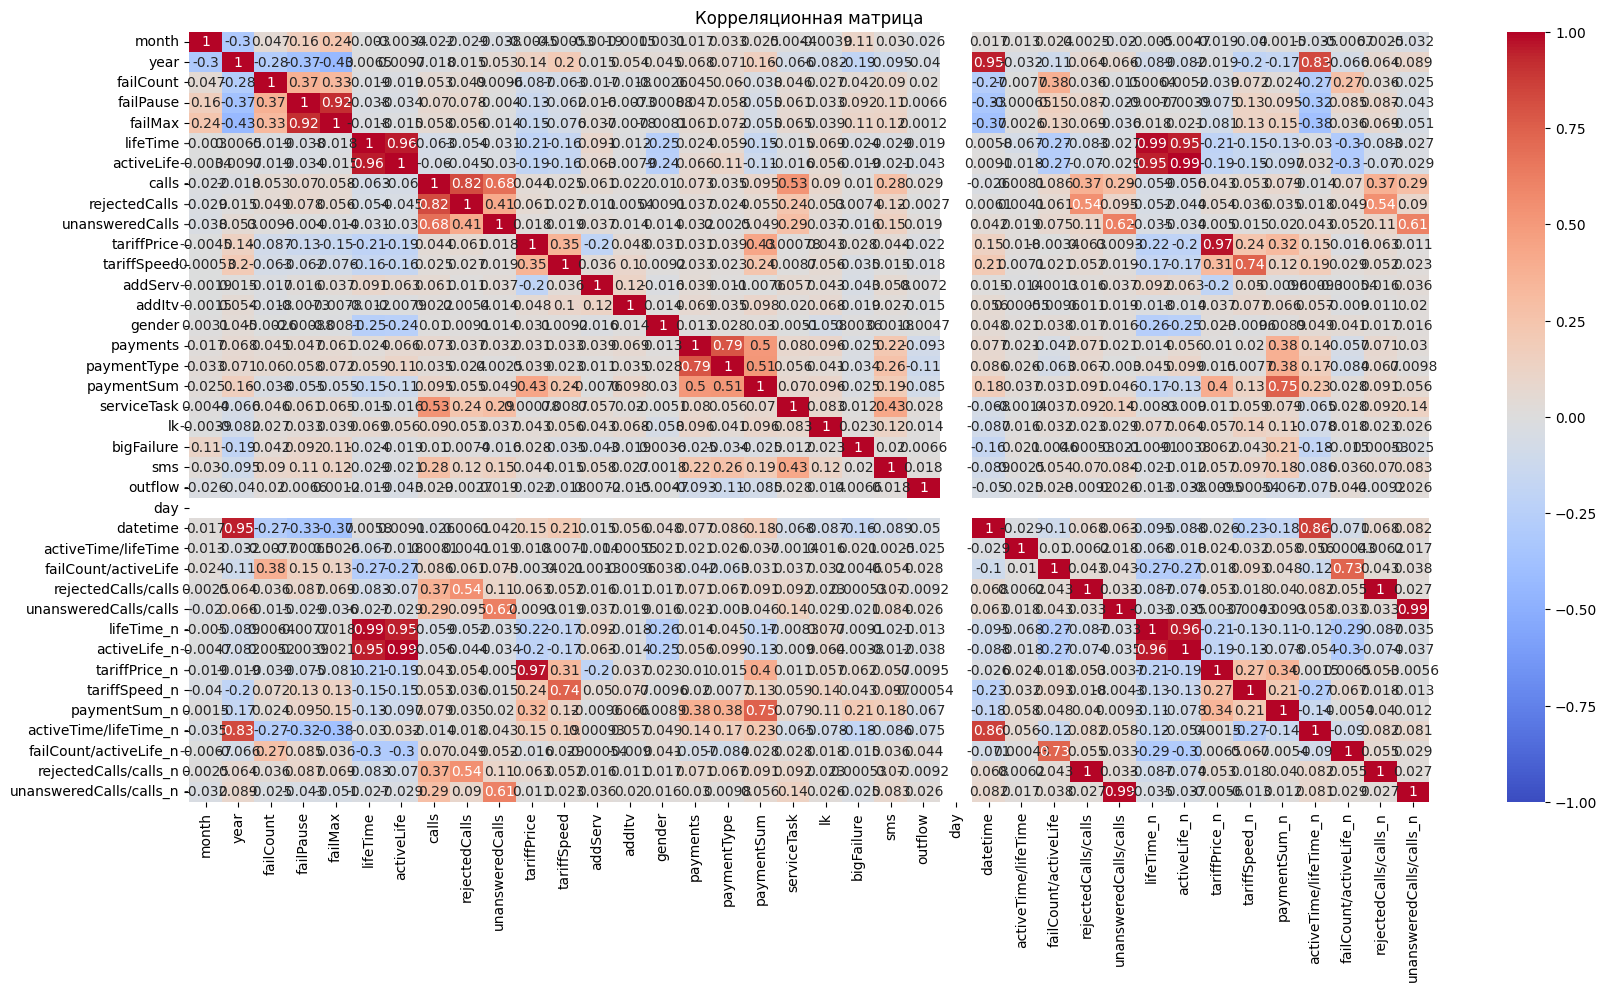

In [62]:
corr = df.corr()

# Построение тепловой карты
plt.figure(figsize=(20, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Корреляционная матрица')
plt.show()

In [63]:
seconds_per_day = 86400 
days_per_year = 365.25 

# Конвертация секунд в годы
df['lifeTime_years'] = df['lifeTime'] / seconds_per_day // days_per_year

In [64]:
df = df[~((df['year'] == 2022) & (df['month'] == 2))]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, '0.0'),
  Text(1, 0, '1.0'),
  Text(2, 0, '2.0'),
  Text(3, 0, '3.0'),
  Text(4, 0, '4.0'),
  Text(5, 0, '5.0'),
  Text(6, 0, '6.0'),
  Text(7, 0, '7.0'),
  Text(8, 0, '8.0'),
  Text(9, 0, '9.0'),
  Text(10, 0, '10.0'),
  Text(11, 0, '11.0'),
  Text(12, 0, '12.0'),
  Text(13, 0, '13.0')])

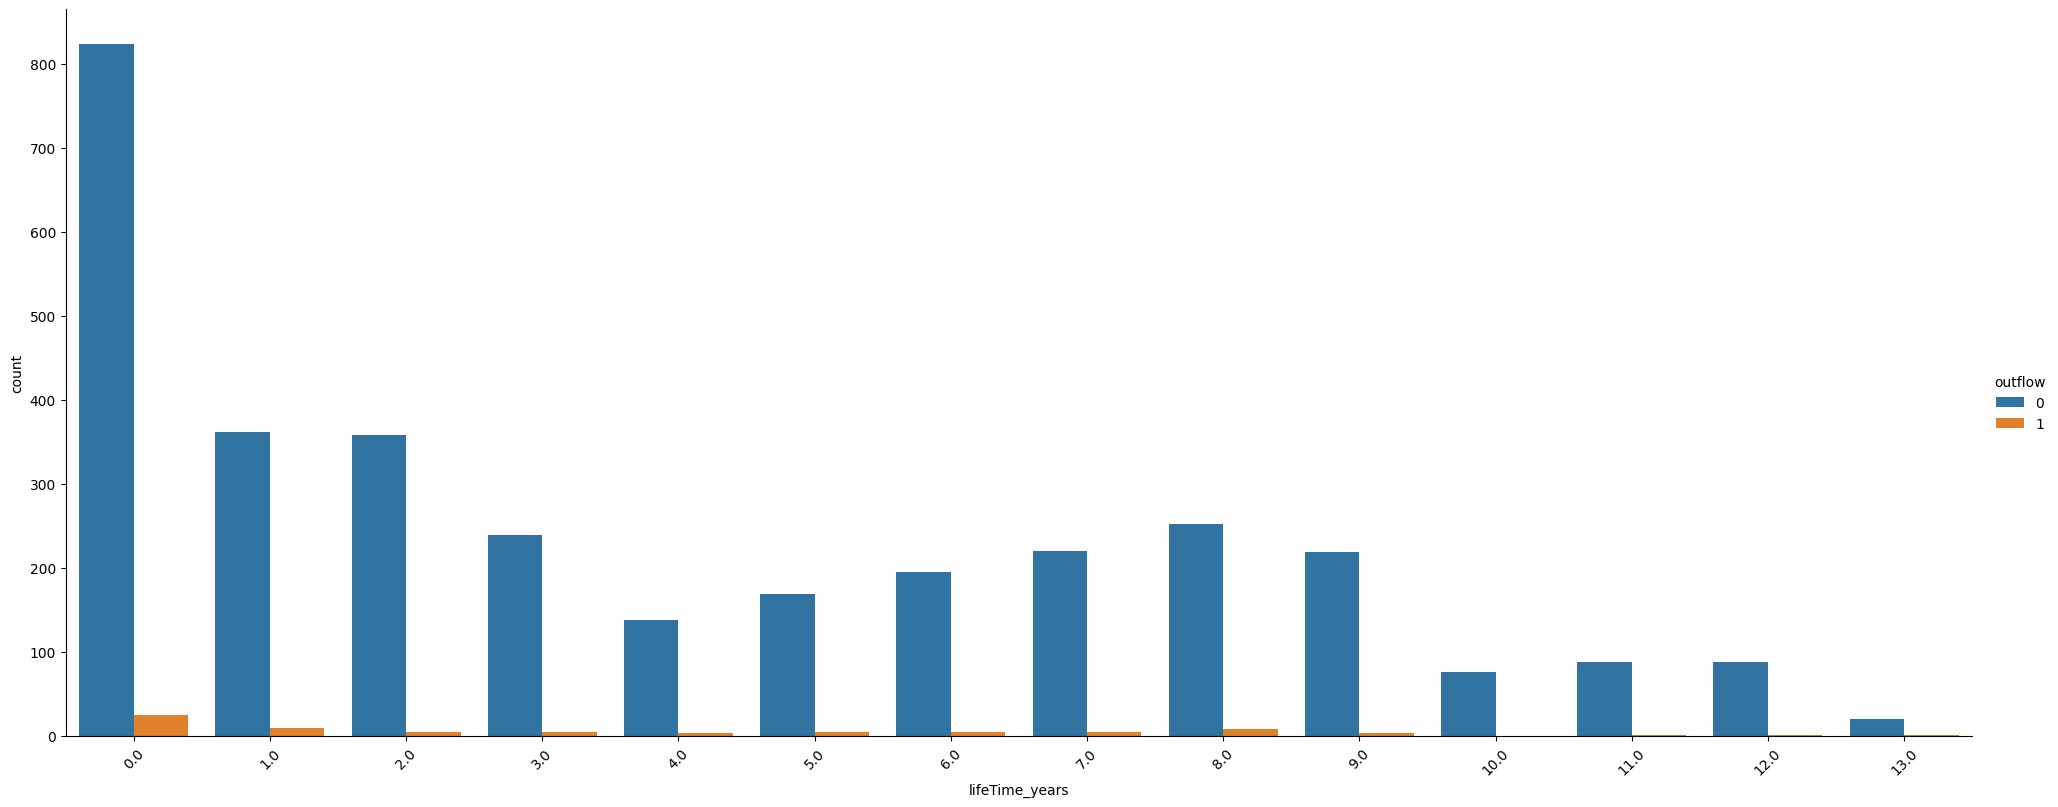

In [65]:
sns.catplot(data=df[df['year'] == 2024], x="lifeTime_years", hue="outflow", kind="count", height=8, aspect=20/8)
plt.xticks(rotation=45)

In [66]:
tmp = df.groupby("payments", as_index=False).agg({"outflow": ["sum", "count"]})
tmp["outflow (%)"] = 100 * tmp["outflow", "sum"] / tmp["outflow", "count"]
tmp.sort_values("outflow (%)").reset_index(drop=True)

payments outflow        outflow (%)
                sum  count            
0        11       0      3    0.000000
1        30       0      1    0.000000
2        29       0      2    0.000000
3        24       0      2    0.000000
4        22       0      1    0.000000
5        21       0      2    0.000000
6        18       0      1    0.000000
7        17       0      1    0.000000
8        15       0      1    0.000000
9        13       0      3    0.000000
10       37       0      1    0.000000
11       44       0      2    0.000000
12        9       0      3    0.000000
13        8       0      7    0.000000
14        7       0     38    0.000000
15       10       0      2    0.000000
16        3     115  17778    0.646867
17        4      21   3096    0.678295
18        5       5    586    0.853242
19        6       2    172    1.162791
20        0      62   2967    2.089653
21        2     717  16848    4.255698
22        1     445   5364    8.296048

In [67]:
tmp = df.groupby("paymentType", as_index=False).agg({"outflow": ["sum", "count"]})
tmp["outflow (%)"] = 100 * tmp["outflow", "sum"] / tmp["outflow", "count"]
tmp.sort_values("outflow (%)").reset_index(drop=True)

paymentType outflow        outflow (%)
                   sum  count            
0            7       0    101    0.000000
1           11       0    104    0.000000
2           13       0      4    0.000000
3            9      31  17202    0.180212
4            0      62   2967    2.089653
5            4       5    238    2.100840
6            8       5    163    3.067485
7            6     726  19258    3.769862
8            5       8    145    5.517241
9            1       8    123    6.504065
10           2       8    109    7.339450
11           3     513   6458    7.943636
12          10       1      9   11.111111

In [68]:
tmp = df.groupby("bigFailure", as_index=False).agg({"outflow": ["sum", "count"]})
tmp["outflow (%)"] = 100 * tmp["outflow", "sum"] / tmp["outflow", "count"]
tmp.sort_values("outflow (%)").reset_index(drop=True)

bigFailure outflow        outflow (%)
                  sum  count            
0           8       0     33    0.000000
1          24       0      1    0.000000
2          28       0      1    0.000000
3          39       0      1    0.000000
4           5       1     80    1.250000
5          11       1     61    1.639344
6          10       2    101    1.980198
7           9       3    137    2.189781
8           7       5    197    2.538071
9           0    1214  42552    2.852980
10          1      68   2030    3.349754
11          2      37    970    3.814433
12          6       4    101    3.960396
13          4       8    165    4.848485
14          3      15    284    5.281690
15         30       9    167    5.389222

In [69]:
tmp = df.groupby("addItv", as_index=False).agg({"outflow": ["sum", "count"]})
tmp["outflow (%)"] = 100 * tmp["outflow", "sum"] / tmp["outflow", "count"]
tmp.sort_values("outflow (%)").reset_index(drop=True)

addItv outflow        outflow (%)
             sum  count            
0      1      48   2582    1.859024
1      0    1319  44299    2.977494

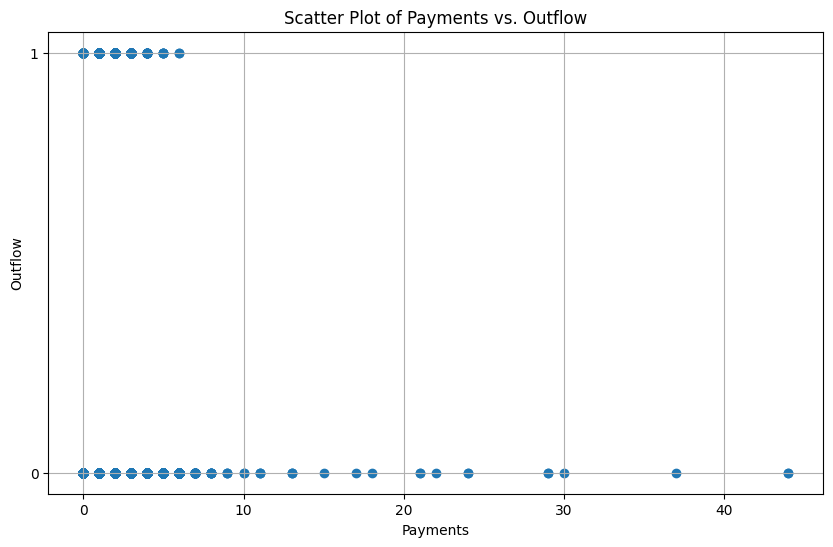

In [70]:
plt.figure(figsize=(10, 6))
plt.scatter(df['payments'], df['outflow'], alpha=1)

# Настройка графика
plt.title('Scatter Plot of Payments vs. Outflow')
plt.xlabel('Payments')
plt.ylabel('Outflow')
plt.yticks([0, 1], ['0', '1'])
plt.grid(True)

# Показать график
plt.show()

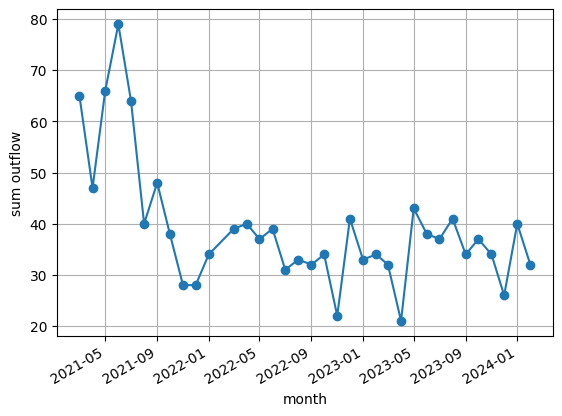

In [71]:
avg_price_per_year = df.groupby('datetime')['outflow'].sum()
avg_price_per_year.plot(kind='line', marker='o')
plt.xlabel('month')
plt.ylabel('sum outflow')
plt.grid(True)
plt.show()

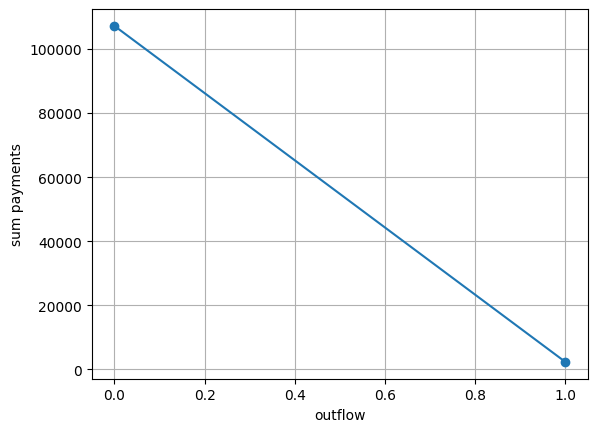

In [72]:
avg_price_per_year = df.groupby('outflow')['payments'].sum()
avg_price_per_year.plot(kind='line', marker='o')
plt.xlabel('outflow')
plt.ylabel('sum payments')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Равномерное распределение')

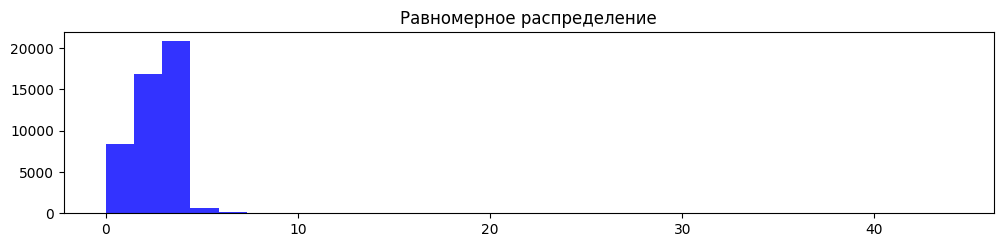

In [73]:
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.hist(df['payments'], bins=30, color='blue', alpha=0.8)
plt.title('Равномерное распределение')

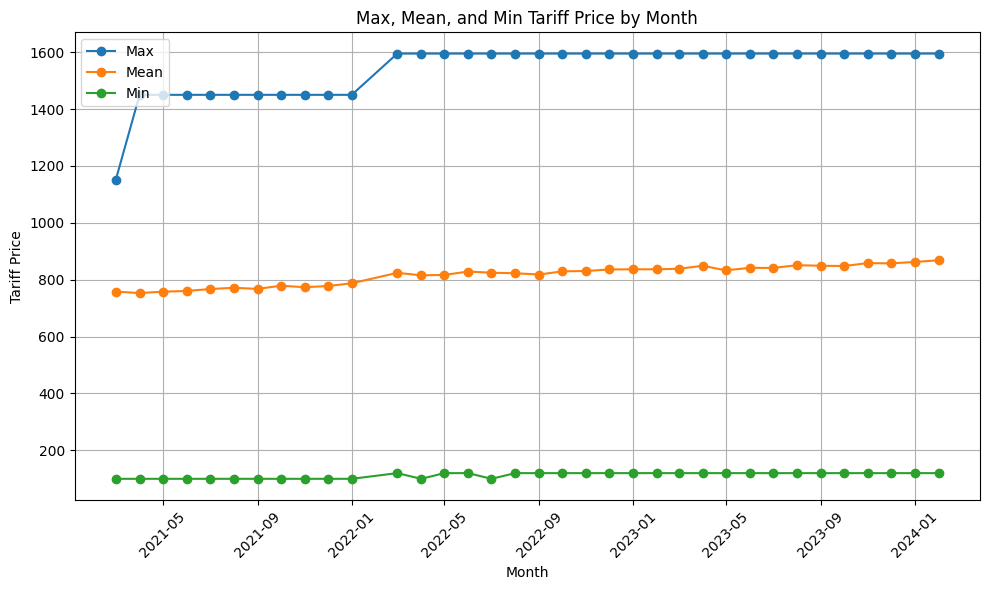

In [74]:
price_stats = df.groupby('datetime')['tariffPrice'].agg(['max', 'mean', 'min'])

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(price_stats.index, price_stats['max'], marker='o', label='Max')
plt.plot(price_stats.index, price_stats['mean'], marker='o', label='Mean')
plt.plot(price_stats.index, price_stats['min'], marker='o', label='Min')

# Настройка графика
plt.xlabel('Month')
plt.ylabel('Tariff Price')
plt.title('Max, Mean, and Min Tariff Price by Month')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)  # Поворот подписей месяцев для удобства
plt.tight_layout()

# Отображение графика
plt.show()

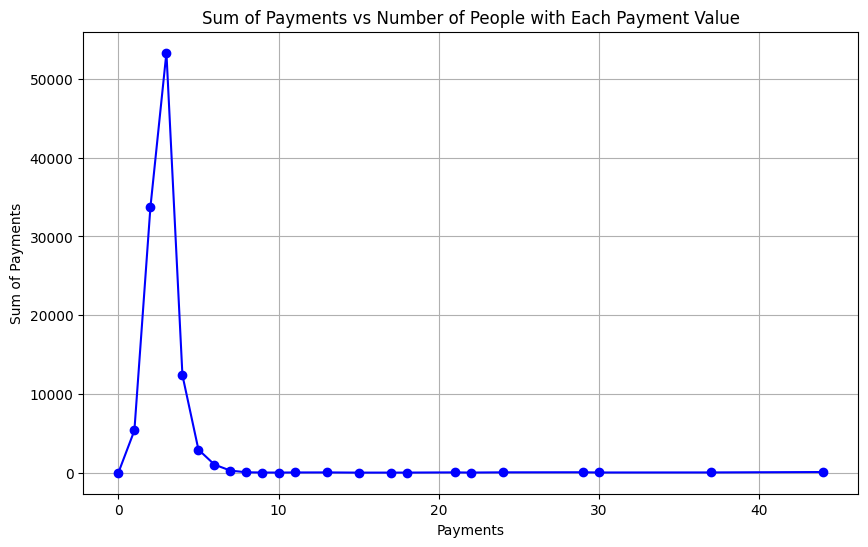

In [75]:
payment_counts = df['payments'].value_counts().sort_index()
payment_sums = df.groupby('payments')['payments'].sum()
plt.figure(figsize=(10, 6))
plt.plot(payment_counts.index, payment_sums, marker='o', linestyle='-', color='b')
plt.xlabel('Payments')
plt.ylabel('Sum of Payments')
plt.grid(True)
plt.title('Sum of Payments vs Number of People with Each Payment Value')
plt.show()

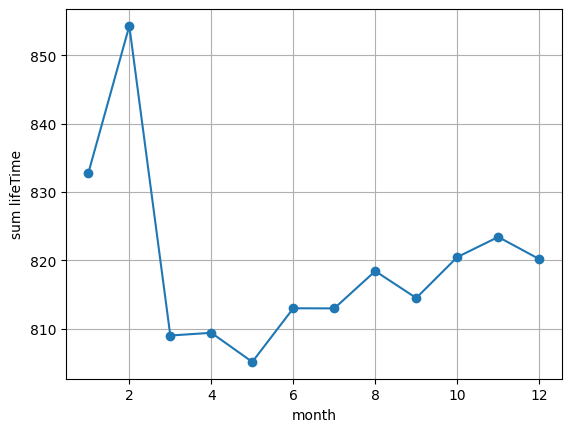

In [76]:
avg_price_per_year = df.groupby('month')['tariffPrice'].mean()
avg_price_per_year.plot(kind='line', marker='o')
plt.xlabel('month')
plt.ylabel('sum lifeTime')
plt.grid(True)
plt.show()

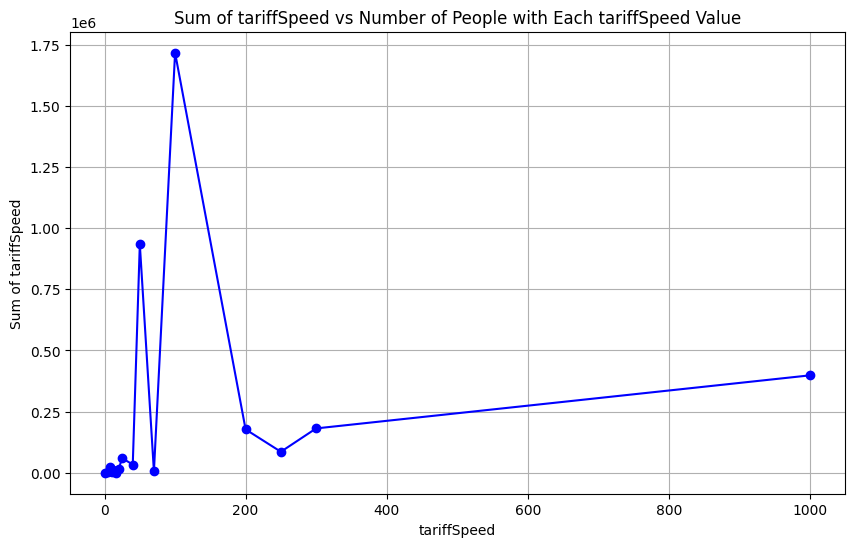

In [77]:
payment_counts = df['tariffSpeed'].value_counts().sort_index()
payment_sums = df.groupby('tariffSpeed')['tariffSpeed'].sum()
plt.figure(figsize=(10, 6))
plt.plot(payment_counts.index, payment_sums, marker='o', linestyle='-', color='b')
plt.xlabel('tariffSpeed')
plt.ylabel('Sum of tariffSpeed')
plt.grid(True)
plt.title('Sum of tariffSpeed vs Number of People with Each tariffSpeed Value')
plt.show()

In [109]:
df1 = df[df['year'] != 2024]
df2 = df[df['year'] == 2024]

In [110]:
df1 = df1.drop(['year', 'datetime', 'day'], axis=1)
df2 = df2.drop(['year', 'datetime', 'day'], axis=1)

In [80]:
# X = df.drop('outflow', axis=1).values
# y = df['outflow'].values


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)

In [111]:
X_train = df1.drop('outflow', axis=1)
X_test = df2.drop('outflow', axis=1)
y_train = df1['outflow']
y_test = df2['outflow']

In [112]:
train_data = Pool(X_train, y_train)
test_data = Pool(X_test, y_test)    

In [119]:
model = CatBoostClassifier(#class_weights=[1, 10],
                           auto_class_weights="SqrtBalanced",
                           learning_rate=0.01,
                        #    eval_metric='F1',
                           eval_metric="AUC:hints=skip_train~false",
                           iterations=5000,
                           l2_leaf_reg=10,
                           max_depth=2
                           ) 

model.fit(
    train_data, 
    eval_set=test_data)

0:	learn: 0.7705717	test: 0.7688513	best: 0.7688513 (0)	total: 9.93ms	remaining: 49.6s
1:	learn: 0.7855196	test: 0.7911792	best: 0.7911792 (1)	total: 17.5ms	remaining: 43.6s
2:	learn: 0.7904756	test: 0.7994385	best: 0.7994385 (2)	total: 25.1ms	remaining: 41.8s
3:	learn: 0.7940517	test: 0.7999153	best: 0.7999153 (3)	total: 33ms	remaining: 41.2s
4:	learn: 0.7942452	test: 0.8021133	best: 0.8021133 (4)	total: 40ms	remaining: 40s
5:	learn: 0.7943615	test: 0.7978991	best: 0.8021133 (4)	total: 49.6ms	remaining: 41.3s
6:	learn: 0.7949872	test: 0.7979676	best: 0.8021133 (4)	total: 57.3ms	remaining: 40.9s
7:	learn: 0.7980614	test: 0.8004734	best: 0.8021133 (4)	total: 66.5ms	remaining: 41.5s
8:	learn: 0.8007937	test: 0.8104966	best: 0.8104966 (8)	total: 73.7ms	remaining: 40.9s
9:	learn: 0.8019456	test: 0.8166778	best: 0.8166778 (9)	total: 82.7ms	remaining: 41.3s
10:	learn: 0.8037705	test: 0.8188265	best: 0.8188265 (10)	total: 93.4ms	remaining: 42.4s
11:	learn: 0.8055736	test: 0.8211357	best: 0.82

Text(0.5, 1.0, 'Feature Importance')

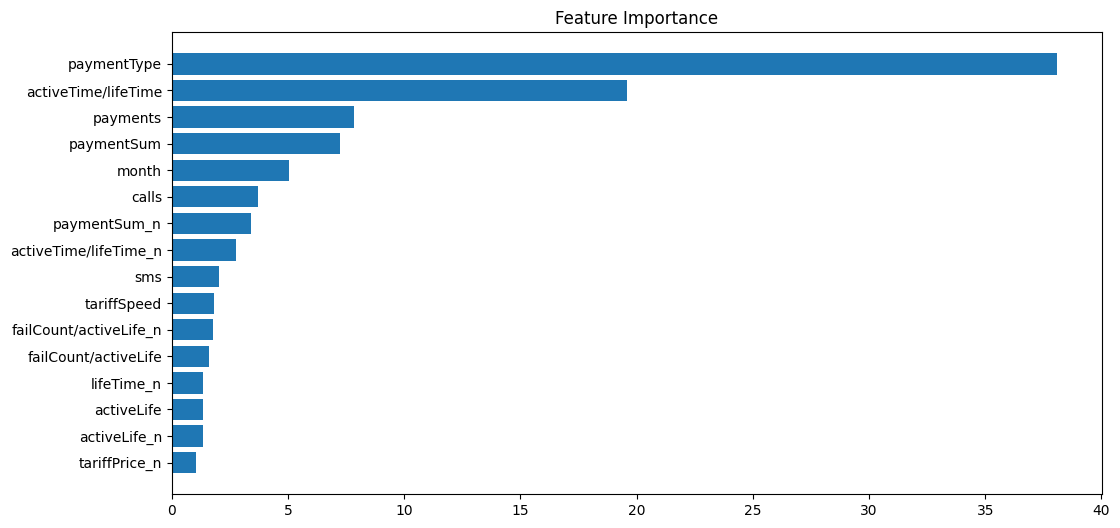

In [120]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance')

In [106]:
threshold = 1

# Определяем индексы фичей, которые имеют важность ниже порога
low_importance_features = np.where(feature_importance < threshold)[0]

low_importance_feature_names = X_train.columns[low_importance_features]

df = df.drop(columns=low_importance_feature_names)


In [121]:
# Предсказание классов
predictions = model.predict(X_test)
print("Predicted classes:", predictions)

# Предсказание вероятностей
probabilities = model.predict_proba(X_test)
print("Predicted probabilities:", probabilities)

Predicted classes: [0 0 0 ... 0 0 0]
Predicted probabilities: [[0.99373962 0.00626038]
 [0.97140936 0.02859064]
 [0.9431445  0.0568555 ]
 ...
 [0.85622381 0.14377619]
 [0.75003778 0.24996222]
 [0.9492977  0.0507023 ]]


In [122]:
probabilities[:,1]

array([0.00626038, 0.02859064, 0.0568555 , ..., 0.14377619, 0.24996222,
       0.0507023 ])

c:\Users\user\Desktop\LEO\ML_outflow_fridom\.venv\Lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


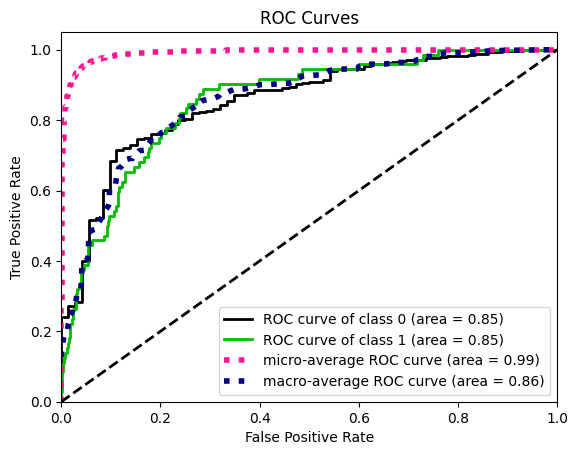

In [124]:
y_true = y_test
y_probas = probabilities
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()

In [158]:
# Задайте порог
threshold = 0.1

# Вероятности для класса 1
prob_class_1 = y_probas[:, 1]

# Прогнозы на основе порога
predictions = (prob_class_1 >= threshold).astype(int)

# Подсчитайте матрицу ошибок
tn, fp, fn, tp = confusion_matrix(y_true, predictions).ravel()

percent_true_positive = (tp / (tp + fn)) * 100
percent_false_positive = (fp / (fp + tn)) * 100

print('Всего 1:', sum(y_test))
print('Всего 0:', X_test['activeLife'].count())
print(f'Истинные положительные: {tp}')
print(f'Ложные положительные: {fp}')
print(f'Ложные отрицательные: {fn}')
print(f'Истинные отрицательные: {tn}')
print(f'Процент верно угаданных единиц: {percent_true_positive:.2f}%')
print(f'Процент нулей, предсказанных как единицы: {percent_false_positive:.2f}%')

Всего 1: 72
Всего 0: 3320
Истинные положительные: 64
Ложные положительные: 945
Ложные отрицательные: 8
Истинные отрицательные: 2303
Процент верно угаданных единиц: 88.89%
Процент нулей, предсказанных как единицы: 29.09%


In [130]:
X_test['activeLife'].count()

3320

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)